### Wstęp do xgboost

Zaczynamy od importów

In [ ]:
! pip install xgboost     # czysty Python
! conda install xgboost   # anaconda

In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import time

Zaczniemy od przejrzenia zestawu danych. Jest to problem regresyjny - jest to cennik mieszkań.

URL: https://www.kaggle.com/shivachandel/kc-house-data

Dane znajdują się w pliku `kc_house_data.csv`.

In [2]:
data = pd.read_csv("./data/kc_house_data.csv")
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
# date - split to year
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

XGBoost jest oddzielną biblioteką niż sklearn. Jest ona kompatybilna z sklearn, natomiast posiada kilka rozszerzeń specyficznych do tej biblioteki. Rzućmy okiem na obiekt reprezentujący model, który będziemy uczyć:

In [4]:
xgb.XGBRegressor?

Część parametrów jest podobna do lasu losowego (`n_estimators`), część odzwierciedla równania, na których bazowana jest funkcja straty. Najbardziej interesujące parametry:

- n_estimators
- learning_rate
- booster
- objective

Więcej na: https://xgboost.readthedocs.io/en/latest/parameter.html

### Przykładowy trening

In [5]:
y = data['price']
x = data.drop(['id', 'price', 'date', 'zipcode'], axis=1)

Podział danych na treningowe oraz testowe

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state= 0)

In [8]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17290 entries, 5268 to 2732
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       17290 non-null  int64  
 1   bathrooms      17290 non-null  float64
 2   sqft_living    17290 non-null  int64  
 3   sqft_lot       17290 non-null  int64  
 4   floors         17290 non-null  float64
 5   waterfront     17290 non-null  int64  
 6   view           17290 non-null  int64  
 7   condition      17290 non-null  int64  
 8   grade          17290 non-null  int64  
 9   sqft_above     17290 non-null  int64  
 10  sqft_basement  17290 non-null  int64  
 11  yr_built       17290 non-null  int64  
 12  yr_renovated   17290 non-null  int64  
 13  lat            17290 non-null  float64
 14  long           17290 non-null  float64
 15  sqft_living15  17290 non-null  int64  
 16  sqft_lot15     17290 non-null  int64  
dtypes: float64(4), int64(13)
memory usage: 2.4 MB


In [9]:
x_train.bedrooms.value_counts()

3     7832
4     5439
2     2260
5     1307
6      225
1      166
7       32
0       11
8        8
9        5
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [10]:
x_train.waterfront.value_counts()

0    17149
1      141
Name: waterfront, dtype: int64

In [11]:
x_train.view.value_counts()

0    15557
2      788
3      406
1      278
4      261
Name: view, dtype: int64

Stworzenie regresora w XGBoost. Istotne parametry: `objective="reg:squarederror"`, `booster="gbtree"`. Seed to ustalenie ziarna losowania (reprodukowalność rozwiązań)

In [12]:
xg_reg = xgb.XGBRegressor(random_state=123, n_estimators=5, max_depth=7)

In [13]:
xg_reg

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=5, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=123,
             reg_alpha=None, reg_lambda=None, ...)

Trening modelu.

In [14]:
%%time

start = time.time()

xg_reg.fit(x_train, y_train)

end = time.time()
print("time: ", end - start)

time:  1.274486780166626
CPU times: total: 1.11 s
Wall time: 1.28 s


Predykcja danych testowych

In [15]:
y_pred = xg_reg.predict(x_test)

In [16]:
y_pred

array([ 315960.88, 1378469.1 ,  428747.9 , ...,  350278.3 ,  196922.05,
        385442.56], dtype=float32)

In [17]:
xg_reg.score(x_test, y_test) #R^2

0.7495393224955608

Obliczmy błąd RMSE (root mean squared error)

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sklearn.metrics

In [19]:
# np.sqrt(np.mean(((y_test - y_pred) ** 2)))

# mean_squared_error(GROUNDTRUTH, PREDYKCJE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)

In [20]:
print("RMSE - gbtree: ", rmse)
print("MAE - gbtree: ", mae)

RMSE - gbtree:  172585.7846398683
MAE - gbtree:  105766.23459547768


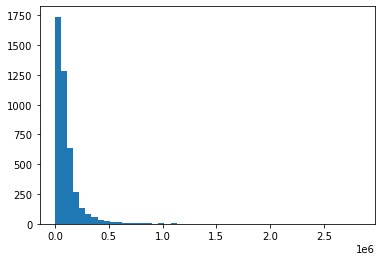

In [21]:
import matplotlib.pyplot as plt

plt.hist(np.abs(y_test - y_pred), bins=50);

In [22]:
y_pred = np.array([200, 240])
y_true = np.array([150, 140])

In [23]:
mae = np.mean(np.abs(y_true - y_pred))
mse = np.mean((y_true - y_pred) ** 2)
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

In [24]:
print(mae, mse, rmse)

75.0 6250.0 79.05694150420949


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

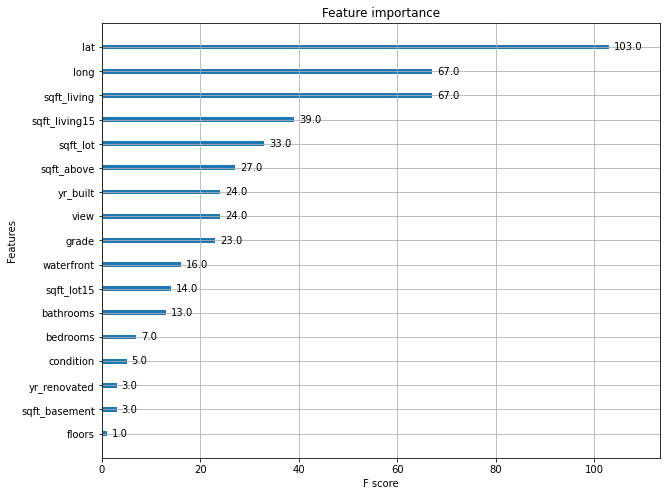

In [25]:
from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 10, 8

xgb.plot_importance(xg_reg)

In [26]:
xgb.plot_importance?

### Alternatywne boostery

Istnieje więcej niż jedna metoda boostowania. `gbtree` opiera się o drzewa, możemy użyć modelu liniowego zamiast drzewa.
Stworzenie regresora (`booster="gblinear"`).

In [27]:
xg_reg_lin = xgb.XGBRegressor(objective="reg:squarederror", seed=123, booster="gblinear", n_estimators=50)

In [28]:
xg_reg_lin.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None, gpu_id=-1,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=50, n_jobs=0,
             num_parallel_tree=None, predictor=None, random_state=123,
             reg_alpha=0, reg_lambda=0, ...)

In [29]:
y_pred = xg_reg_lin.predict(x_test)

In [30]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [31]:
print("RMSE: ", rmse)

RMSE:  230000.7495140943


### Nieliniowe przekształcenie

Jeżeli wykreślimy cenę, zauważymy, że dystrybucja cen nie przypomina rozkładu normalnego. Jest to bardzo niezrównoważony rozkład.

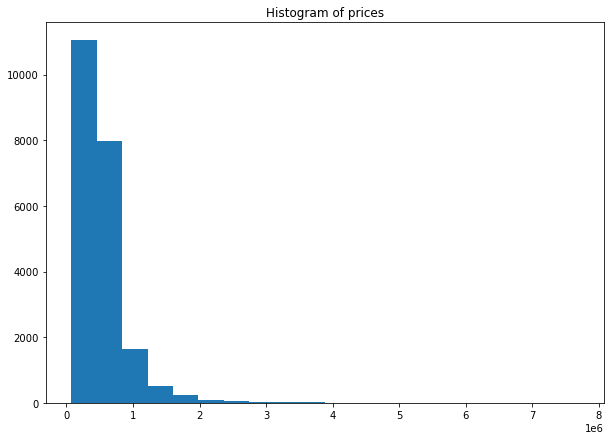

In [32]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 10, 7

plt.hist(data['price'], bins=20)
_ = plt.title("Histogram of prices")

In [33]:
data['price'].head()

0    221900.0
1    538000.0
2    180000.0
3    604000.0
4    510000.0
Name: price, dtype: float64

In [34]:
np.log10(data['price'].head())

0    5.346157
1    5.730782
2    5.255273
3    5.781037
4    5.707570
Name: price, dtype: float64

In [35]:
min(np.log10(data['price'].head())), max(np.log10(data['price'].head()))

(5.2552725051033065, 5.781036938621132)

In [36]:
10 ** np.log10(data['price'].head())

0    221900.0
1    538000.0
2    180000.0
3    604000.0
4    510000.0
Name: price, dtype: float64

Spróbujmy przekształcić ten zestaw danych - np. przy pomocy przekształcenia logarytmicznego (dla danych finansowych często jest to pożyteczne przekształcenie).

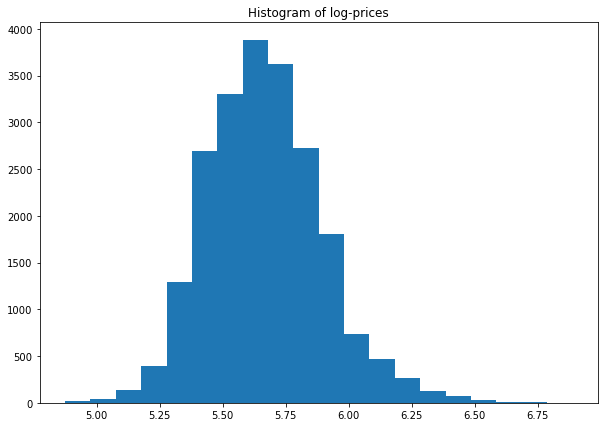

In [37]:
plt.hist(np.log10(data['price']), bins=20)
_ = plt.title("Histogram of log-prices")

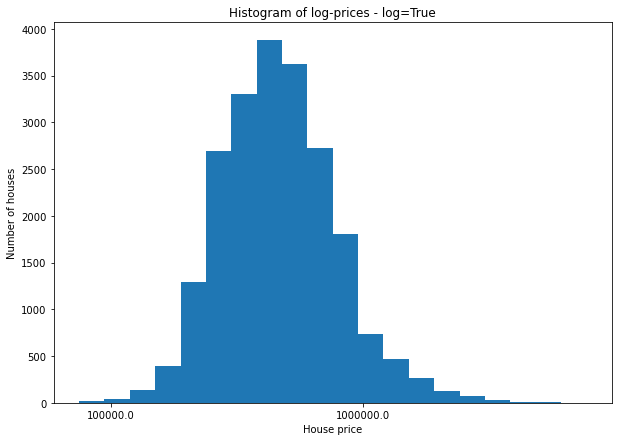

In [38]:
# wykreślenie cen z osią X odpowiadającą rzeczywistej cenie, a nie wykładnikowi
# jeden sposób: https://stackoverflow.com/questions/6855710/how-to-have-logarithmic-bins-in-a-python-histogram
# drugi sposób: https://kite.com/python/examples/1870/matplotlib-change-x-axis-tick-labels

# wykorzystano przekształcenie odwrotne, które jest funkcją wykładniczą np.exp

plt.hist(np.log10(data['price']), bins=20)
_ = plt.title("Histogram of log-prices - log=True")
plt.xlabel("House price")
plt.ylabel("Number of houses")
_ = plt.xticks(np.arange(5, 7), np.floor(10 ** (np.arange(5, 7))))

# Zadanie 1

Wykorzystując przekształcenie logarytmiczne sprawdź w jaki sposób poprawia to modele. Sprawdź `gbtree` oraz `gblinear` (analogiczie do modeli powyżej).

Aby Twój model mógł być porównany z poprzednim, musisz wykorzystać tą samą miarę błędu. W tym celu - dokonaj przekształcenia odwrotnego na wynikach (funkcji wykładniczej) a następnie porównaj wyniki regresji w oryginalnej skali oraz wartości docelowych dla tych przykładów.

In [39]:
# x, y

y_transformed = np.log10(y) #10 **
y_transformed

0        5.346157
1        5.730782
2        5.255273
3        5.781037
4        5.707570
           ...   
21608    5.556303
21609    5.602060
21610    5.604335
21611    5.602060
21612    5.511883
Name: price, Length: 21613, dtype: float64

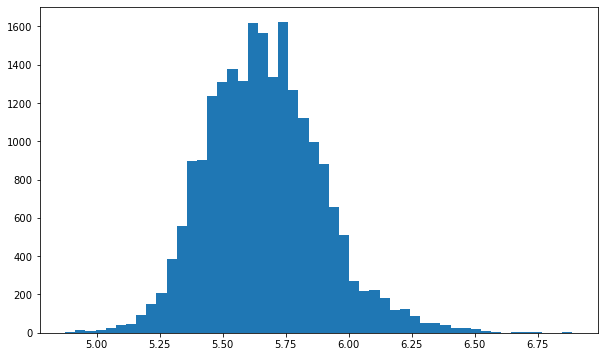

In [41]:
plt.figure(figsize=(10, 6))
_ = plt.hist(y_transformed, bins=50)

In [40]:
train_x, test_x, train_y, test_y, train_yt, test_yt = train_test_split(
    x, y, y_transformed, test_size=0.2, random_state=123
)
test_y.shape, test_yt.shape

((4323,), (4323,))

In [42]:
results = {}

for variant in ["transformed", "not_transformed"]:
    for booster in ["gbtree", "gblinear"]:
        print(variant, booster)
        if variant == "transformed":
            this_train_y = train_yt
        else:
            this_train_y = train_y
        model = xgb.XGBRegressor(booster=booster, n_estimators=100)
        model.fit(train_x, this_train_y)
        pred = model.predict(test_x)
        if variant == "transformed": #odwrocenie przeksztalcenia logarytmicznego
            pred = 10 ** pred
        score = mean_absolute_error(test_y, pred)
        results[(variant, booster)] = score

results

transformed gbtree
transformed gblinear
not_transformed gbtree
not_transformed gblinear


{('transformed', 'gbtree'): 65555.37105128093,
 ('transformed', 'gblinear'): 149870.73662314942,
 ('not_transformed', 'gbtree'): 67671.37879330038,
 ('not_transformed', 'gblinear'): 154453.09459395963}

In [49]:
model = xgb.XGBRegressor(booster="gbtree", n_estimators=25)
model.fit(train_x, train_y)
pred = model.predict(test_x)
np.sqrt(mean_squared_error(test_y, pred))

117663.0689666674

In [50]:
model = xgb.XGBRegressor(booster="gblinear", n_estimators=25)
model.fit(train_x, train_y)
pred = model.predict(test_x)
np.sqrt(mean_squared_error(test_y, pred))

245982.10450930145

In [51]:
model = xgb.XGBRegressor(booster="gbtree", n_estimators=25)
model.fit(train_x, train_yt)
pred = 10 ** model.predict(test_x)
np.sqrt(mean_squared_error(test_y, pred))

123672.13596317454

In [52]:
model = xgb.XGBRegressor(booster="gblinear", n_estimators=25)
model.fit(train_x, train_yt)
pred = 10 ** model.predict(test_x)
np.sqrt(mean_squared_error(test_y, pred))

448863.1877029203